# The Future of Market Sentiment

Using classical technical analysis which tends to focus on the market sentiment 
of the moment we apply modern deep learning to see the near-term future and attempt
avoid misfires.

Our algorithm of choice, DeepAR, enables forecasting on very large datasets composed of multiple 
timeseries. This is a typical investment portfolio. Unlike other forecasting algorithms such as 
EMS, Prophet, and ARIMA, DeepAR uses a deep learning encoder/decoder model to discover behavioral
relationships in the data that are otherwise inaccessible. We expect this model to yeild non-intuitive 
results that are specifically relevant to the instruments in our basket.

In [43]:
import os
import json
import boto3
import sagemaker
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

%matplotlib inline

## Add the symbols for your portfolio

In [3]:
portfolio = ('AMZN', 'GOOG', 'FB', 'AAPL', 'SPY', 'TSLA')

## Other settings

In [2]:
base_job_name = 'sparkSummitDemo'

# Training data range. Choose a minimum 2-year timeframe that best matches current conditions. 
start_date = '2014-01-01'
end_date = '2016-01-01'

s3_bucket = '2021-demos'
s3_prefix = 'sparkSummit'

## Get historical data

Any timeframe can be used to train data. We're living in a time of economic collapes, 
not the first. Recent periods such as the 2008 recession might be a good choice. Ensure that 
the instruments in your portfolio existed at the time period of your training data.

In [4]:
# Get prices for each symbol in time range
portfolio_history = []
for ticker in portfolio: 
    portfolio_history.append(web.DataReader(ticker, data_source = 'yahoo', start=start_date, end=end_date))

## Add indicators to price action history

### Exponential moving averages: 13- and 50-day

EMAs are persistent. We'll need them later.

In [5]:
for ticker in portfolio_history:
    ticker['EMA13'] = ticker.Close.ewm(span=13).mean()
    ticker['EMA50'] = ticker.Close.ewm(span=50).mean()

### MACD - Moving Average Convergence/Divergence

MACD measures trend health. EMAs calculated in MACD are ephemeral. We can toss them once we've calculated the MACD histogram.

In [6]:
for i, ticker in enumerate(portfolio_history):
    EMA12 = ticker.Close.ewm(span=12, adjust=False).mean()
    EMA26 = ticker.Close.ewm(span=26, adjust=False).mean()
    MACD = EMA12-EMA26
    signal = MACD.ewm(span=9, adjust=False).mean()
    portfolio_history[i]['MACDhistogram'] = MACD - signal
    del EMA12, EMA26, MACD

## Slow Stochastics

The poorly-named yet highly-effective "Slow Stochastics" is a trigger indicator. An upward cross in the lower 20% is bullish, a downward cross in the upper 10% is bearish.  Again, All we care about is the fast and slow line. Ephemeral values are tossed aside. 

```
%K = (Current Close - Lowest Low)/(Highest High - Lowest Low) * 100
%D = 3-day SMA of %K
```

* %K is generally called the "slow line", and %D the "fast line"
* Lowest Low = lowest low for the look-back period
* Highest High = highest high for the look-back period

In [7]:
for i, ticker in enumerate(portfolio_history):
    rollingLow, rollingHigh = ticker.Low.rolling(14).min(), ticker.High.rolling(14).max()
    fastLine = 100 * (ticker.Close - rollingLow) / (rollingHigh - rollingLow) 
    slowLine = fastLine.rolling(3).mean()
    portfolio_history[i]['fast_stoch'] = fastLine
    portfolio_history[i]['slow_stoch'] = slowLine

In [8]:
portfolio_history[0].head()

,High,Low,Open,Close,Volume,Adj Close,EMA13,EMA50,MACDhistogram,fast_stoch,slow_stoch
Date,,,,,,,,,,,
2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001,397.970001,397.970001,0.000000,NaN,NaN
2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002,397.146156,397.189702,-0.097641,NaN,NaN
2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005,395.789531,395.955364,-0.332827,NaN,NaN
2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999,396.484988,396.505548,-0.181011,NaN,NaN
2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013,397.929955,397.676770,0.173278,NaN,NaN


## Plot the last 50 days

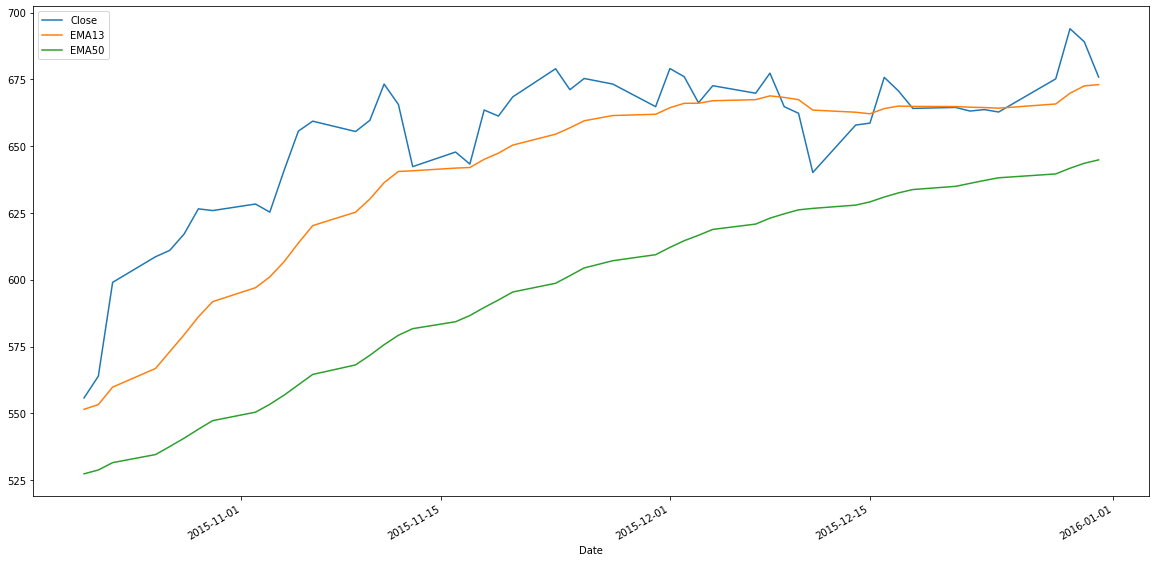

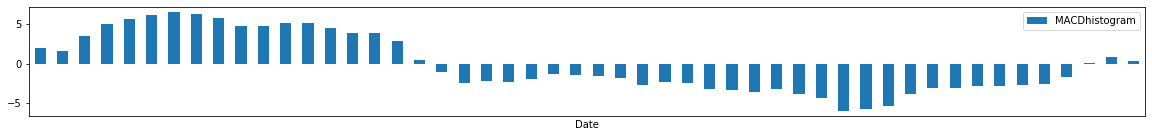

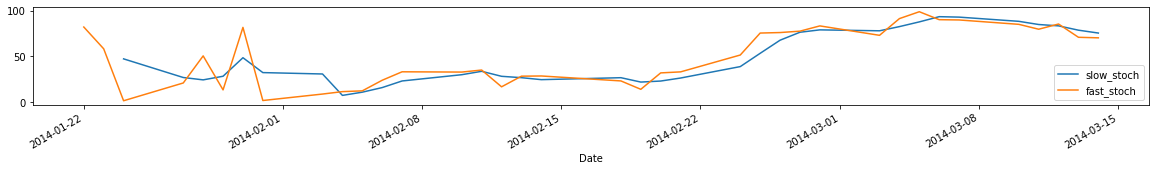

In [9]:
days = 50

emaCross = portfolio_history[0][['Close', 'EMA13', 'EMA50']].tail(days)
emaCross.plot(figsize=(20,10))

slowStochastic = portfolio_history[0][:days][['slow_stoch', 'fast_stoch']].tail(days)
MACDhistogram = portfolio_history[0][['MACDhistogram']].tail(days)

MACDhistogram.plot(figsize=(20,2), kind='bar', xticks=[])
slowStochastic.plot(figsize=(20,2))

## Format the Training and Test datasets

Use the entire dataset for training. We need to forcast 5 different indicators: 

* The 13-day EMA
* The 50-day EMA
* The MACD Histogram, and
* Both Slow Stochastics indicators

We'll align them on parallel paths as single factor targets. Data will align on the timestamp index. 

In [28]:
start_date = str(portfolio_history[0].index[0])
start_date

'2014-01-02 00:00:00'

In [35]:
train_EMA13 = [
    {
        "start": start_date,
        "target": ticker.EMA13.tolist() 
    } for ticker in portfolio_history
]
train_EMA50 = [
    {
        "start": start_date,
        "target": ticker.EMA50.tolist() 
    } for ticker in portfolio_history
]
train_MACDhistogram = [
    {
        "start": start_date,
        "target": ticker.MACDhistogram.tolist() 
    } for ticker in portfolio_history
]
train_fast_stoch = [
    {
        "start": start_date,
        "target": ticker.fast_stoch.tolist() 
    } for ticker in portfolio_history
]
train_slow_stoch = [
    {
        "start": start_date,
        "target": ticker.slow_stoch.tolist() 
    } for ticker in portfolio_history
]

For the test set we'll use the last 50 values of each indicator.

In [36]:
periods = 50

test_EMA13 = [
    {
        "start": start_date,
        "target": ticker.EMA13.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_EMA50 = [
    {
        "start": start_date,
        "target": ticker.EMA50.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_MACDhistogram = [
    {
        "start": start_date,
        "target": ticker.MACDhistogram.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_fast_stoch = [
    {
        "start": start_date,
        "target": ticker.fast_stoch.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_slow_stoch = [
    {
        "start": start_date,
        "target": ticker.slow_stoch.tail(periods).tolist() 
    } for ticker in portfolio_history
]

Datasets are prepared. Ship them up to S3.

In [40]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

write_dicts_to_file("train_EMA13.json", train_EMA13)
write_dicts_to_file("test_EMA13.json", test_EMA13)

write_dicts_to_file("train_EMA50.json", train_EMA50)
write_dicts_to_file("test_EMA50.json", test_EMA50)

write_dicts_to_file("train_MACDhistogram.json", train_MACDhistogram)
write_dicts_to_file("test_MACDhistogram.json", test_MACDhistogram)

write_dicts_to_file("train_fast_stoch.json", train_fast_stoch)
write_dicts_to_file("test_fast_stoch.json", test_fast_stoch)

write_dicts_to_file("train_slow_stoch.json", train_slow_stoch)
write_dicts_to_file("test_slow_stoch.json", test_slow_stoch)

s3 = boto3.resource('s3')
bucket = s3.Bucket(s3_bucket)

for dataset in ['EMA13', 'EMA50', 'MACDhistogram', 'fast_stoch', 'slow_stoch']:
    filename = 'train_' + dataset + '.json'
    with open(filename, 'rb') as data:
        key = s3_prefix + '/data/' + dataset + '/' + filename
        result = bucket.put_object(Key=key, Body=data)
        print('Uploaded file to {}'.format(result))

    filename = 'test_' + dataset + '.json'
    with open(filename, 'rb') as data:
        key = s3_prefix + '/data/' + dataset + '/' + filename
        result = bucket.put_object(Key=key, Body=data)
        print('Uploaded file to {}'.format(result))

Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/EMA13/train_EMA13.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/EMA13/test_EMA13.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/EMA50/train_EMA50.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/EMA50/test_EMA50.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/MACDhistogram/train_MACDhistogram.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/MACDhistogram/test_MACDhistogram.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/fast_stoch/train_fast_stoch.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/fast_stoch/test_fast_stoch.json')
Uploaded file to s3.Object(bucket_name='2021-demos', key='sparkSummit/data/slow_stoch/train_slow_stoch.json')
Uploaded file to s3.Object(bucket_name='20

## Setup DeepAR in SageMaker

In [44]:
sagemaker_session = sagemaker.Session()
role = os.getenv('SAGEMAKER_ROLE')
region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

## Training/Testing data parameters

Set the hyperparameters for reuse on every indicator.

In [47]:
freq = 'D'
context_length = prediction_length = 14

hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "20",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [52]:
# ['EMA13', 'EMA50', 'MACDhistogram', 'fast_stoch', 'slow_stoch']:

estimator_EMA13 = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-demo',
    output_path="s3://{}/{}/output/EMA13/train_EMA13.json".format(s3_bucket, s3_prefix)
)
estimator_EMA13.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/{}/data/EMA13/train_EMA13.json".format(s3_bucket, s3_prefix),
    "test":  "s3://{}/{}/data/EMA13/test_EMA13.json".format(s3_bucket, s3_prefix)
}

estimator_EMA13.fit(inputs=data_channels, wait=True)

2020-05-27 23:26:50 Starting - Starting the training job...
2020-05-27 23:26:52 Starting - Launching requested ML instances.........
2020-05-27 23:28:27 Starting - Preparing the instances for training...
2020-05-27 23:29:11 Downloading - Downloading input data...
2020-05-27 23:29:51 Training - Training image download completed. Training in progress..Arguments: train
[05/27/2020 23:29:54 INFO 140380795041600] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

[05/27/2020 23:30:01 INFO 140380795041600] Epoch[9] Batch[5] avg_epoch_loss=3.610673
[05/27/2020 23:30:01 INFO 140380795041600] #quality_metric: host=algo-1, epoch=9, batch=5 train loss <loss>=3.61067326864
[05/27/2020 23:30:01 INFO 140380795041600] Epoch[9] Batch [5]#011Speed: 1679.24 samples/sec#011loss=3.610673
[05/27/2020 23:30:01 INFO 140380795041600] Epoch[9] Batch[10] avg_epoch_loss=3.580914
[05/27/2020 23:30:01 INFO 140380795041600] #quality_metric: host=algo-1, epoch=9, batch=10 train loss <loss>=3.54520301819
[05/27/2020 23:30:01 INFO 140380795041600] Epoch[9] Batch [10]#011Speed: 1731.75 samples/sec#011loss=3.545203
[05/27/2020 23:30:01 INFO 140380795041600] processed a total of 676 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 631.9558620452881, "sum": 631.9558620452881, "min": 631.9558620452881}}, "EndTime": 1590622201.542752, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1590622200.910721}

[05/27/20

[05/27/2020 23:30:11 INFO 140380795041600] Epoch[25] Batch[5] avg_epoch_loss=3.402109
[05/27/2020 23:30:11 INFO 140380795041600] #quality_metric: host=algo-1, epoch=25, batch=5 train loss <loss>=3.4021093448
[05/27/2020 23:30:11 INFO 140380795041600] Epoch[25] Batch [5]#011Speed: 1824.15 samples/sec#011loss=3.402109
[05/27/2020 23:30:11 INFO 140380795041600] Epoch[25] Batch[10] avg_epoch_loss=3.337861
[05/27/2020 23:30:11 INFO 140380795041600] #quality_metric: host=algo-1, epoch=25, batch=10 train loss <loss>=3.26076364517
[05/27/2020 23:30:11 INFO 140380795041600] Epoch[25] Batch [10]#011Speed: 1611.99 samples/sec#011loss=3.260764
[05/27/2020 23:30:11 INFO 140380795041600] processed a total of 654 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 651.4370441436768, "sum": 651.4370441436768, "min": 651.4370441436768}}, "EndTime": 1590622211.540948, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1590622210.889017}

[05/

[05/27/2020 23:30:26 INFO 140380795041600] Epoch[50] Batch[0] avg_epoch_loss=3.010138
[05/27/2020 23:30:26 INFO 140380795041600] #quality_metric: host=algo-1, epoch=50, batch=0 train loss <loss>=3.01013803482
[05/27/2020 23:30:26 INFO 140380795041600] Epoch[50] Batch[5] avg_epoch_loss=3.128632
[05/27/2020 23:30:26 INFO 140380795041600] #quality_metric: host=algo-1, epoch=50, batch=5 train loss <loss>=3.12863234679
[05/27/2020 23:30:26 INFO 140380795041600] Epoch[50] Batch [5]#011Speed: 1884.50 samples/sec#011loss=3.128632
[05/27/2020 23:30:26 INFO 140380795041600] processed a total of 608 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 547.9350090026855, "sum": 547.9350090026855, "min": 547.9350090026855}}, "EndTime": 1590622226.774845, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1590622226.22645}

[05/27/2020 23:30:26 INFO 140380795041600] #throughput_metric: host=algo-1, train throughput=1109.31703754 records/se

[05/27/2020 23:30:36 INFO 140380795041600] Epoch[66] Batch[5] avg_epoch_loss=3.119591
[05/27/2020 23:30:36 INFO 140380795041600] #quality_metric: host=algo-1, epoch=66, batch=5 train loss <loss>=3.11959095796
[05/27/2020 23:30:36 INFO 140380795041600] Epoch[66] Batch [5]#011Speed: 1885.36 samples/sec#011loss=3.119591
[05/27/2020 23:30:36 INFO 140380795041600] Epoch[66] Batch[10] avg_epoch_loss=3.265755
[05/27/2020 23:30:36 INFO 140380795041600] #quality_metric: host=algo-1, epoch=66, batch=10 train loss <loss>=3.44115285873
[05/27/2020 23:30:36 INFO 140380795041600] Epoch[66] Batch [10]#011Speed: 1856.27 samples/sec#011loss=3.441153
[05/27/2020 23:30:36 INFO 140380795041600] processed a total of 665 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 589.043140411377, "sum": 589.043140411377, "min": 589.043140411377}}, "EndTime": 1590622236.528322, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1590622235.938753}

[05/27

[05/27/2020 23:30:46 INFO 140380795041600] Epoch[83] Batch[0] avg_epoch_loss=3.054347
[05/27/2020 23:30:46 INFO 140380795041600] #quality_metric: host=algo-1, epoch=83, batch=0 train loss <loss>=3.05434703827
[05/27/2020 23:30:46 INFO 140380795041600] Epoch[83] Batch[5] avg_epoch_loss=3.079000
[05/27/2020 23:30:46 INFO 140380795041600] #quality_metric: host=algo-1, epoch=83, batch=5 train loss <loss>=3.07899999619
[05/27/2020 23:30:46 INFO 140380795041600] Epoch[83] Batch [5]#011Speed: 1883.25 samples/sec#011loss=3.079000
[05/27/2020 23:30:46 INFO 140380795041600] Epoch[83] Batch[10] avg_epoch_loss=3.162811
[05/27/2020 23:30:46 INFO 140380795041600] #quality_metric: host=algo-1, epoch=83, batch=10 train loss <loss>=3.26338481903
[05/27/2020 23:30:46 INFO 140380795041600] Epoch[83] Batch [10]#011Speed: 1753.26 samples/sec#011loss=3.263385
[05/27/2020 23:30:46 INFO 140380795041600] processed a total of 666 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 646.581172943115

[05/27/2020 23:30:56 INFO 140380795041600] Epoch[99] Batch[0] avg_epoch_loss=3.063439
[05/27/2020 23:30:56 INFO 140380795041600] #quality_metric: host=algo-1, epoch=99, batch=0 train loss <loss>=3.0634393692
[05/27/2020 23:30:56 INFO 140380795041600] Epoch[99] Batch[5] avg_epoch_loss=3.135212
[05/27/2020 23:30:56 INFO 140380795041600] #quality_metric: host=algo-1, epoch=99, batch=5 train loss <loss>=3.13521170616
[05/27/2020 23:30:56 INFO 140380795041600] Epoch[99] Batch [5]#011Speed: 1898.46 samples/sec#011loss=3.135212
[05/27/2020 23:30:56 INFO 140380795041600] Epoch[99] Batch[10] avg_epoch_loss=3.147847
[05/27/2020 23:30:56 INFO 140380795041600] #quality_metric: host=algo-1, epoch=99, batch=10 train loss <loss>=3.16301031113
[05/27/2020 23:30:56 INFO 140380795041600] Epoch[99] Batch [10]#011Speed: 1829.93 samples/sec#011loss=3.163010
[05/27/2020 23:30:56 INFO 140380795041600] processed a total of 653 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 589.3020629882812


2020-05-27 23:31:15 Uploading - Uploading generated training model
2020-05-27 23:31:15 Completed - Training job completed
Training seconds: 124
Billable seconds: 124


In [53]:
predictor_EMA13 = estimator_EMA13.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

## Prepare inference request from holdout set

For prediction we only care about the next 14 days. And, we want a prediction based on current market action. This dataset just like the training set can be tuned. For the demo we're getting the last 50 days.

In [75]:
from datetime import datetime

holdout_start = (datetime.now() - BDay(50)).strftime("%Y-%m-%d")
print(holdout_start)

holdout_end = (datetime.now() - BDay(1)).strftime("%Y-%m-%d")
print(holdout_end)

2020-03-18
2020-05-26


In [77]:
holdout_set = []
for ticker in portfolio: 
    holdout_set.append(web.DataReader(ticker, data_source = 'yahoo', start=holdout_start, end=holdout_end))

In [82]:
request = {
    "instances": [
        {
            "start": holdout_start,
            "target": holdout_set[0].Close.tolist()
        }
    ],
    "configuration": {
         "num_samples": holdout_set[0].shape[0],
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}

In [84]:
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_JSON

infer = RealTimePredictor( endpoint=predictor_EMA13.endpoint, 
                                sagemaker_session=sagemaker_session, 
                                serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON)

result = infer.predict(request)

In [85]:
predictions = json.loads(result.decode('utf-8'))['predictions'][0]
preds = pd.DataFrame(predictions['quantiles']['0.5'])

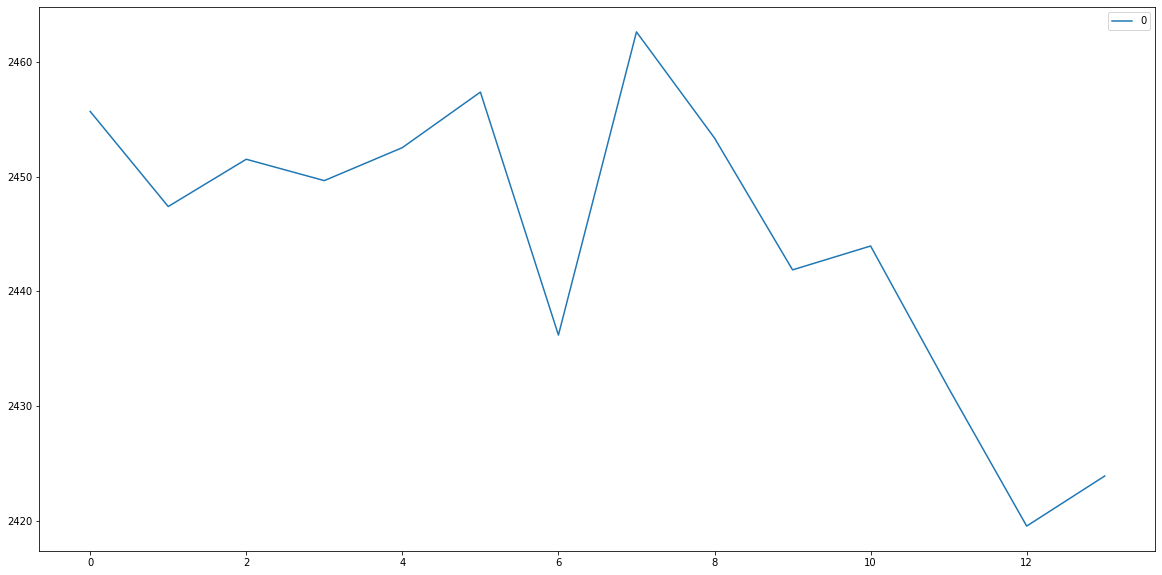

In [86]:
preds.plot(figsize=(20,10))